# Exercise: Convolutional Neural Networks - Solution
$\renewcommand{\real}{\mathbb{R}}$
$\renewcommand{\xb}{\mathbf{x}}$
$\renewcommand{\yb}{\mathbf{y}}$
$\renewcommand{\zb}{\mathbf{z}}$
$\renewcommand{\wb}{\mathbf{w}}$
$\renewcommand{\Xb}{\mathbf{X}}$
$\renewcommand{\Lb}{\mathbf{L}}$
$\DeclareMathOperator*{\argmin}{argmin}$


We will implement our own neural networks with PyTorch. 


## Dependencies

Before you start, please make sure to install the following packages:

**torch**: The framework we will use for training deep nets.

**torchvision**: Helper package consisting of popular datasets, model architectures, and common image transformations for computer vision. We will use it for loading the MNIST dataset and to perform simple data transformations.

**torchsummary**: Helper package for visualizing deep net architectures.

Please use the following commands to install all the dependencies:

`pip install torch torchvision torchsummary`

`conda install -c conda-forge nomkl`

In [1]:
# 3rd party
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Lambda, Compose
from torchsummary import summary
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

# Project files.
from helpers import accuracy, visualize_convolution, load_blackwhite_image, DrawingPad

In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [3]:
device = torch.device(('cpu', 'cuda')[torch.cuda.is_available()])

## Part 1: PyTorch

### 1.1: Motivation

In the first part of the exercise we will revisit the MNIST dataset of hand-written digits, and we will train deep net models to classify the digits. Instead of doing all the hard coding work manually, we will simplify our life by using a deep learning framework: PyTorch.

Last week we have implemented our own Multi-Layer Perceptron (MLP), where we defined both the forward pass and back-propagation together with a simple optimizer (SGD update rule) and successfully trained it to perform classification. Given the amount of code written, one can imagine that prototyping with various NN architectures and training strategies might get tedious. That is where PyTorch (and other deep learning frameworks) come into play.

### 1.2: About PyTorch

[PyTorch](https://pytorch.org/) is an optimized tensor library for deep learning using GPUs and CPUs. It allows
for fast prototyping by providing high-level access to all necessary building blocks, including NN layers, activation functions, loss functions, and optimizers, to name a few. Most importantly, however, PyTorch implements the [autograd](https://pytorch.org/docs/stable/autograd.html) package, which allows for automatic differentiation of the operations we use to define NN architectures. In other words, one only has to implement the forward pass, namely to combine desired layers, while the **backpropagation is computed automatically**.

### 1.3: Basic pipeline

To define and train deep net models, one would usually implement the following steps:

    1. Load the dataset.
    2. Define and instantiate a deep net architecture.
    3. Choose or implement a loss function (such as the mean squared error).
    4. Choose and instantiate an optimizer (such as the SGD).
    5. For each batch in the dataset:
        5.1. Load a batch.
        5.2. Run a forward pass through your model.
        5.3. Compute the loss.
        5.4. Run a backward pass, i.e., compute gradients of the loss w.r.t. the trainable parameters (weights).
        5.5. Update the weights using the optimizer.
        5.6. Zero-out the accumulated gradients before the next iteration.
        
We will see this exact pipeline in our code as well.

### 1.4: Essential bulding blocks

This section gives a high-level summary of the most important components representing the bare minimum that you will need to start playing with PyTorch and deep net models. You might want to skim through the official tutorials as well, namely [What is PyTorch](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py) and [Neural Networks](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py). Here is the list of the components that will be explained in more detail along with the code blocks.

  - **nn.Module**: Base class for NN architectures.
  - **criterion**: A loss function.
  - **backward-pass**: Derivatives computed by the auto-diff system.
  - **optimizer**: Updates the trainable parameters (weights) during training.

### 1.5: Loading the data

We are at step (1) of the training pipeline. PyTorch provides us with the `Dataset` and `DataLoader` classes, which manage the loading, shuffling and transformations of the data. Within our training loop we will treat our dataset as an *iterator*, which returns the batches of data and associated labels.

As was the case of previous week, we will work with the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset, where each sample is stored as a $28 \times 28$ pixels grayscale image. The data samples are loaded as `torch.Tensor` data type.

In [4]:
batch_size = 128

batch_size = 128

# Flattening transformation.

##############################################
# MAC and LINUX
##############################################
# flatten = Lambda(lambda x: x.flatten())
# nw_tr = 4
# nw_te = 4
##############################################

##############################################
# WINDOWS
##############################################
class Flatten:
    def __call__(self, x):
        return x.flatten()
flatten = Flatten()
nw_tr = 0
nw_te = 0
##############################################

# Dataset and DataLoader for MLP.
ds_fc_tr = MNIST('data', train=True, download=True, transform=Compose([ToTensor(), flatten]))
ds_fc_te = MNIST('data', train=False, download=True, transform=Compose([ToTensor(), flatten]))
dl_fc_tr = DataLoader(ds_fc_tr, batch_size=batch_size, shuffle=False, num_workers=nw_tr)
dl_fc_te = DataLoader(ds_fc_te, batch_size=batch_size, shuffle=False, num_workers=nw_te)

# Dataset for CNN.
ds_cnn_tr = MNIST('data', train=True, download=True, transform=ToTensor())
ds_cnn_te = MNIST('data', train=False, download=True, transform=ToTensor())
dl_cnn_tr = DataLoader(ds_cnn_tr, batch_size=batch_size, shuffle=False, num_workers=nw_tr)
dl_cnn_te = DataLoader(ds_cnn_te, batch_size=batch_size, shuffle=False, num_workers=nw_te)

ntr = len(ds_fc_tr)
nva = len(ds_fc_te)
print('Loaded {} tr and {} va samples.'.format(ntr, nva))

Loaded 60000 tr and 10000 va samples.


### 1.6: Multi-Layer Perceptron (MLP)

#### Architecture

We are at step (2) of the training pipeline. We will start by implementing an MLP consisting of a 1D input layer (we flatten, i.e., vectorize, the input image) of shape ($784$, ), $3$ hidden fully connected layers and an output layer of shape ($10$, ), as we have $10$ classes. 

#### Optimization criterion

We would like to interpret the output vector $\hat{\yb} \in \real^{10}$ as the probabilities of data sample $\xb \in \real^{784}$ belonging to each class $j \in \{1, 2, ... 10\}$. Therefore, we will make use of the activation function **softmax** defined as:

$$ \hat{\yb}^{(j)} = P(\text{class}=j|\zb) = \frac{\exp{\zb^{\top}\wb_{(j)}}}{\sum_{k=1}^{10}{\exp{\zb^{\top}\wb_{(k)}}}}. $$

The softmax guarantees that $\sum_{k=1}^{10}{\hat{\yb}_{k}} = 1$, meaning that out predicted vector $\yb$ is indeed a valid probability distribution over classes. 

Finally, we would like to match the predicted distribution $\hat{\yb}$ to the ground truth (GT) one $\yb$, where $\yb$ is given as a one-hot encoding ($\yb$ is all zeros except for a $1$ at the index $j$, if $j$ is the correct class to be predicted). The optimization criterion of choice is then to minimize the [**cross-entropy**](https://en.wikipedia.org/wiki/Cross_entropy) (CE) of $\hat{\yb}$ and $\yb$. Therefore our final loss function $L$ is defined as:

$$ L = \text{CE}(\yb, \hat{\yb}).$$

Thankfully, PyTorch provides the implementation of $L$, so you will only really need to provide the output $\zb$ (i.e. the 10-dimensional output of your last layer before the softmax). We will get back to $L$ later.

---

#### nn.Module
Each custom NN architecture you choose to implement has to subclass the [`nn.Module`](https://pytorch.org/docs/stable/nn.html#module), which conveniently keeps track of all the trainable parameters. From the programmer's perspective, you have to implement the constructor (`__init__`) and override the `forward()` function:

- **\_\_init__()**

You will define your layers (e.g., fully connected layer, 2D convolutional layer, etc.) in the constructor, and `nn.Module` will automatically keep track of all the weights these layers contain.

- **forward()**

This function really defines the architecture, as you will sequentally call your layers in the desired order. Each time you call `forward()` (every training iteration), the so-called **computational graph** is built. It is a directed acyclic graph (DAG) of nodes corresponding to the operations you have called. Each node defines the derivative of its outputs w.r.t. its inputs. The computational graph is then traversed in the reversed fashion once you call `backward()` and the derivatives are computed.

All the trainable parameters, which your model consists of, can be accessed via a call to `model.parameters()` implemented in `nn.Module`. This comes in handy once instantiating your optimizer as you have to pass all the parameters you want it to manage.

---

Your task is to define the MLP as depicted in the figure below. Please refer to the documentation and focus on
the classes `nn.Linear` to define the layers and `F.relu` to call the activation funtion.

<img src="img/mlp.png" width=800></img>

In [5]:
class FC(nn.Module):
    """ Standard Multi layer perceptron for classification into 10 
    classes. Consists of 4 FC layers, ReLU activations are used 
    for the first 3.
    """
    def __init__(self):
        """ Constructor, layers definitions go here. Only specify
        those layers which have any trainable parameters (but for
        instance not the activation functions as the ones we use 
        do not have any trainable parameters). """
        super(FC, self).__init__()

        self._fc1 = nn.Linear(784, 512)
        self._fc2 = nn.Linear(512, 256)
        self._fc3 = nn.Linear(256, 128)
        self._fc4 = nn.Linear(128, 10)

    def forward(self, x):
        """ Feed-forward pass, this is where the actual computation happens
        and the computational graph is built (from scratch each time this 
        function is called). """
        
        x = F.relu(self._fc1(x))
        x = F.relu(self._fc2(x))
        x = F.relu(self._fc3(x))
        return self._fc4(x)
    
# Instantiate the model.
model_fc = FC().to(device)

**Q:** How many learnable parameters (weights) does this model have?

**A:** (784 + 1) * 512 + (512 + 1) * 256 + (256 + 1) * 128 + (128 + 1) * 10 = 567434

### 1.7: Inspecting the model architecture

Let us check the model architecture and see how many trainable parameters we really use. For this purpose we will use the `torchsummary` package.

Note the number of trainable parameters.

In [6]:
summary(model_fc, input_size=(28 * 28, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
            Linear-2                  [-1, 256]         131,328
            Linear-3                  [-1, 128]          32,896
            Linear-4                   [-1, 10]           1,290
Total params: 567,434
Trainable params: 567,434
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.16
Estimated Total Size (MB): 2.17
----------------------------------------------------------------


### 1.8: Loss function

We are at step (3) of our pipeline. As explained above, our loss function $L$ will be $\text{CE}(\yb, \hat{\yb})$, which is provided for us by PyTorch, please refer to the documentation of [`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html?highlight=cross_entropy#torch.nn.CrossEntropyLoss).

There are [many commonly used loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions) defined in the `torch.nn` module, and you can also implement your own using PyTorch operations. 

Your task is to instantiate the CE loss function.

In [7]:
# Define the loss fuction.
criterion = nn.CrossEntropyLoss()

### 1.9: Optimizer
We are at step (4) of the pipeline. The [Optimizer](https://pytorch.org/docs/stable/optim.html) updates the weights given the currently computed gradients. It can be a simple state-less function (such as SGD) or a more advanced one, which keeps track of additional information about the weights and the gradients (such as a running mean), which can be used for smarter update rules.

We will opt for the simplest case, the state-less SGD. Your task is to instantiate this optimizer, please refer to [`optim.SGD`](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD).

In [8]:
learning_rate = 1e-1
opt = torch.optim.SGD(model_fc.parameters(), lr=learning_rate)

### 1.10: Training loop

We are at step (5) of our pipeline. We would like to define a training loop where we iterate over the training samples and train our model. Let us define a function `train_model()` which will be used for training any architecture we come up with.

Fill in the code that follows the steps 5.2 - 5.6 of our training pipeline. For running the backward pass, use the function [`backward()`](https://pytorch.org/docs/stable/autograd.html?highlight=backward#torch.autograd.backward). For zeroing out the accumulated gradients, use the function [`zero_grad()`](https://pytorch.org/docs/stable/nn.html?highlight=zero_grad#torch.nn.Module.zero_grad).

In [9]:
def train_model(model, crit, opt, dl_tr, dl_te, epochs):
    for ep in range(epochs):
        # Training.
        model.train()
        for it, batch in enumerate(dl_tr):
            # 5.1 Load a batch.
            x, y = [d.to(device) for d in batch]

            # 5.2 Run forward pass.
            logits = model(x)
            
            # 5.3 Compute loss (using 'criterion').
            loss = crit(logits, y)
            
            # 5.4 Run backward pass.
            loss.backward()
            
            # 5.5 Update the weights using optimizer.
            opt.step()
            
            # 5.6 Zero-out the accumualted gradients.
            model.zero_grad()

            print('\rEp {}/{}, it {}/{}: loss train: {:.2f}, accuracy train: {:.2f}'.
                  format(ep + 1, epochs, it + 1, len(dl_tr), loss,
                         accuracy(logits, y)), end='')

        # Validation.
        model.eval()
        with torch.no_grad():
            acc_run = 0
            for it, batch in enumerate(dl_te):
                # Get batch of data.
                x, y = [d.to(device) for d in batch]
                curr_bs = x.shape[0]
                acc_run += accuracy(model(x), y) * curr_bs
            acc = acc_run / nva

            print(', accuracy test: {:.2f}'.format(acc))

### Training the model

In [10]:
epochs = 5
train_model(model_fc, criterion, opt, dl_fc_tr, dl_fc_te, epochs)

Ep 1/5, it 469/469: loss train: 0.34, accuracy train: 0.94, accuracy test: 0.89
Ep 2/5, it 469/469: loss train: 0.26, accuracy train: 0.97, accuracy test: 0.93
Ep 3/5, it 469/469: loss train: 0.22, accuracy train: 0.97, accuracy test: 0.95
Ep 4/5, it 469/469: loss train: 0.21, accuracy train: 0.98, accuracy test: 0.96
Ep 5/5, it 469/469: loss train: 0.21, accuracy train: 0.98, accuracy test: 0.97


## Part 2: Convolutional Neural Networks (CNNs)

Our 4-layer MLP network works well, reaching a test accuracy of ~0.96. However, this network uses ~0.5M weights. We can use even deeper architectures with less weights and take advantage of the 2D structure of the input data (images) using CNNs.

### 2.1: LeNet-5

Let us define a simple CNN with 2 convolutional layers with max-pooling and 3 FC layers. In particular, we will implement a variant of the architecture called [LeNet-5 introduced by Yann LeCun in 1999](http://yann.lecun.com/exdb/publis/pdf/lecun-99.pdf). 


Your task is to define a simple LeNet-5 architecture depicted in the figure below. Check the architecture using `torchsummary` and comment on the number of parameters. Finally train the model. To specify the layers, please refer to the functions [`Conv2d`](https://pytorch.org/docs/stable/nn.html#conv2d) and [`max_pool2d`](https://pytorch.org/docs/stable/nn.html?highlight=max_pool2d#torch.nn.functional.max_pool2d).

<img src="img/lenet5.png" width=800></img>


In [11]:
class CNN_LeNet(nn.Module):
    """ CNN, expects input shape (28, 28).
    """
    def __init__(self):
        super(CNN_LeNet, self).__init__()

        self._conv2d1 = nn.Conv2d(1, 6, 3, 1, padding=1)
        self._conv2d2 = nn.Conv2d(6, 16, 3, 1, padding=1)
        self._fc1 = nn.Linear(7 * 7 * 16, 120)
        self._fc2 = nn.Linear(120, 84)
        self._fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self._conv2d1(x)), 2)
        x = F.max_pool2d(F.relu(self._conv2d2(x)), 2)
        x = x.reshape((x.shape[0], -1))
        x = F.relu(self._fc1(x))
        x = F.relu(self._fc2(x))
        return self._fc3(x)
    
# Instantiate the model.
model_lenet = CNN_LeNet().to(device)

**Q:** What is the number of trainable parameters in our LeNet model?

**A:** (6 * 3 * 3 * 1 + 6) + (16 * 3 * 3 * 6 + 16) + (784 + 1) * 120 + (120 + 1) * 84 + (84 + 1) * 10 = 106154

Let us check the architecture again and the number of trainable parameters. We can directly see that this architecture needs just about 20% of the parameters the MLP used.

In [12]:
# Print out the architecture and check the number of parameters.
summary(model_lenet, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]              60
            Conv2d-2           [-1, 16, 14, 14]             880
            Linear-3                  [-1, 120]          94,200
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 106,154
Trainable params: 106,154
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.40
Estimated Total Size (MB): 0.47
----------------------------------------------------------------


In [13]:
# Train the model
epochs = 5
opt_lenet = torch.optim.SGD(model_lenet.parameters(), lr=learning_rate)
train_model(model_lenet, F.cross_entropy, opt_lenet, dl_cnn_tr, dl_cnn_te, epochs)

Ep 1/5, it 469/469: loss train: 0.26, accuracy train: 0.92, accuracy test: 0.89
Ep 2/5, it 469/469: loss train: 0.23, accuracy train: 0.95, accuracy test: 0.93
Ep 3/5, it 469/469: loss train: 0.21, accuracy train: 0.96, accuracy test: 0.95
Ep 4/5, it 469/469: loss train: 0.19, accuracy train: 0.98, accuracy test: 0.97
Ep 5/5, it 469/469: loss train: 0.16, accuracy train: 0.99, accuracy test: 0.98


### 2.2: 3-layered CNN

Let us now define an even deeper CNN with 3 convolutional layers and only 2 FC layers. This network should reach higher accuracy (or converge faster) and still use fewer parameters than the previous architectures.

Your task is to implement a 3-layer CNN as depicted in the figure below. Check the number of parameters using `torchsummary`. Train the model and play around with the number of filters (kernels) used by every layer. Comment on your findings.

<img src="img/cnn.png" width=800></img>

In [14]:
class CNN(nn.Module):
    """ CNN, expects input shape (28, 28).
    """
    def __init__(self, filters=(16, 32, 64)):
        super(CNN, self).__init__()

        self._conv2d1 = nn.Conv2d(1, filters[0], 3, 1, padding=1)
        self._conv2d2 = nn.Conv2d(filters[0], filters[1], 3, 1, padding=1)
        self._conv2d3 = nn.Conv2d(filters[1], filters[2], 3, 1, padding=1)
        self._fc1 = nn.Linear(3 * 3 * filters[2], 128)
        self._fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self._conv2d1(x)), 2)
        x = F.max_pool2d(F.relu(self._conv2d2(x)), 2)
        x = F.max_pool2d(F.relu(self._conv2d3(x)), 2)
        x = x.reshape((x.shape[0], -1))
        x = F.relu(self._fc1(x))
        return self._fc2(x)

# Instantiate the model.
filters = [16, 32, 64]
model_cnn = CNN(filters).to(device)

In [15]:
# Print out the architecture and number of parameters.
summary(model_cnn, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
            Conv2d-2           [-1, 32, 14, 14]           4,640
            Conv2d-3             [-1, 64, 7, 7]          18,496
            Linear-4                  [-1, 128]          73,856
            Linear-5                   [-1, 10]           1,290
Total params: 98,442
Trainable params: 98,442
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.38
Estimated Total Size (MB): 0.55
----------------------------------------------------------------


In [16]:
# Train the model.
opt_cnn = torch.optim.SGD(model_cnn.parameters(), lr=learning_rate)
train_model(model_cnn, F.cross_entropy, opt_cnn, dl_cnn_tr, dl_cnn_te, epochs)

Ep 1/5, it 469/469: loss train: 0.31, accuracy train: 0.96, accuracy test: 0.93
Ep 2/5, it 469/469: loss train: 0.25, accuracy train: 0.97, accuracy test: 0.97
Ep 3/5, it 469/469: loss train: 0.23, accuracy train: 0.99, accuracy test: 0.98
Ep 4/5, it 469/469: loss train: 0.21, accuracy train: 0.99, accuracy test: 0.98
Ep 5/5, it 469/469: loss train: 0.19, accuracy train: 0.99, accuracy test: 0.99


### 2.3: Trying out your own input

We have provided a tool for you to draw your own digits and test your network. Play around with the inputs to get a sense of how accurate your model is. Use the button `reset` to reset the canvas and `predict` to run the prediction on the current canvas image. You can use the button `blur` to blur your drawn image so that it looks closer to the samples from the training set.

<IPython.core.display.Javascript object>


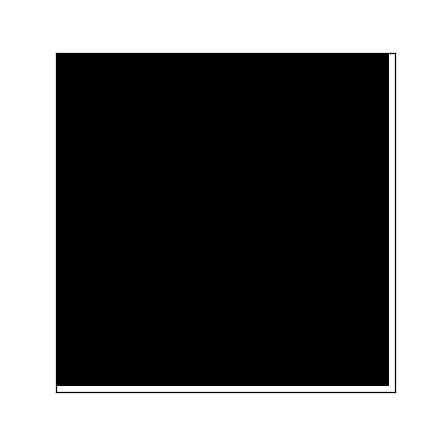

Button(description='reset', style=ButtonStyle())

Button(description='blur', style=ButtonStyle())

Button(description='predict', style=ButtonStyle())

In [17]:
dp = DrawingPad((28, 28), model_lenet, device)